In [11]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
from functools import partial
import json
import traceback
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt 

import imlib as im
from imlib.dtype import *
import numpy as np
import pylib
import tensorflow as tf
import tflib as tl

import data
import models

import os
import time
from PIL import Image

os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline

In [5]:
experiment_name = 128
with open('./output/%s/setting.txt' % experiment_name) as f:
    args = json.load(f)

# model
atts = args['atts']
n_att = len(atts)
img_size = args['img_size']
shortcut_layers = args['shortcut_layers']
inject_layers = args['inject_layers']
enc_dim = args['enc_dim']
dec_dim = args['dec_dim']
dis_dim = args['dis_dim']
dis_fc_dim = args['dis_fc_dim']
enc_layers = args['enc_layers']
dec_layers = args['dec_layers']
dis_layers = args['dis_layers']

label = args['label']
use_stu = args['use_stu']
stu_dim = args['stu_dim']
stu_layers = args['stu_layers']
stu_inject_layers = args['stu_inject_layers']
stu_kernel_size = args['stu_kernel_size']
stu_norm = args['stu_norm']
stu_state = args['stu_state']
multi_inputs = args['multi_inputs']
rec_loss_weight = args['rec_loss_weight']
one_more_conv = args['one_more_conv']

dataroot = './data/celeba/'

gpu = 'all'
if gpu != 'all':
    os.environ['CUDA_VISIBLE_DEVICES'] = gpu

use_cropped_img = args['use_cropped_img']
thres_int = args['thres_int']

Using selected images: [202559]
 [*] Loading checkpoint succeeds! Copy variables from ./output/128/checkpoints/Epoch_(139)_(947of947).ckpt!
['Bald', 'Bangs', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Bushy_Eyebrows', 'Eyeglasses', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'No_Beard', 'Pale_Skin', 'Young']
[[0 1 0 0 1 0 0 0 1 0 1 0 0]]
duration of process No.0 attribution(no-change) of image 202559.png is: 1.8707168102264404
[[1 0 0 0 1 0 0 0 1 0 1 0 0]]
duration of process No.1 attribution(Bald) of image 202559.png is: 0.6658806800842285
[[0 0 0 0 1 0 0 0 1 0 1 0 0]]
duration of process No.2 attribution(Bangs) of image 202559.png is: 0.6411159038543701
[[0 1 1 0 0 0 0 0 1 0 1 0 0]]
duration of process No.3 attribution(Black_Hair) of image 202559.png is: 0.6952688694000244
[[0 1 0 1 0 0 0 0 1 0 1 0 0]]
duration of process No.4 attribution(Blond_Hair) of image 202559.png is: 0.6109089851379395
[[0 1 0 0 0 0 0 0 1 0 1 0 0]]
duration of process No.5 attribution(Brown_Hair) of image 20255

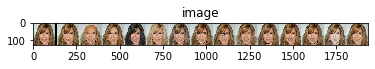

In [19]:
# change single attribution
test_slides = False
test_int = 1.0
img = [202559]
print('Using selected images:', img)

# ==============================================================================
# =                                   graphs                                   =
# ==============================================================================

# data
sess = tl.session()
te_data = data.Celeba(dataroot, atts, img_size, 1, part='test', sess=sess, crop=not use_cropped_img, im_no=img)

# models
Genc = partial(models.Genc, dim=enc_dim, n_layers=enc_layers, multi_inputs=multi_inputs)
Gdec = partial(models.Gdec, dim=dec_dim, n_layers=dec_layers, shortcut_layers=shortcut_layers,
               inject_layers=inject_layers, one_more_conv=one_more_conv)
Gstu = partial(models.Gstu, dim=stu_dim, n_layers=stu_layers, inject_layers=stu_inject_layers,
               kernel_size=stu_kernel_size, norm=stu_norm, pass_state=stu_state)

# inputs
xa_sample = tf.placeholder(tf.float32, shape=[None, img_size, img_size, 3])
_b_sample = tf.placeholder(tf.float32, shape=[None, n_att])
raw_b_sample = tf.placeholder(tf.float32, shape=[None, n_att])

# sample
test_label = _b_sample - raw_b_sample if label == 'diff' else _b_sample
if use_stu:
    x_sample = Gdec(Gstu(Genc(xa_sample, is_training=False),
                         test_label, is_training=False), test_label, is_training=False)
else:
    x_sample = Gdec(Genc(xa_sample, is_training=False), test_label, is_training=False)
    
# ==============================================================================
# =                                    test                                    =
# ==============================================================================

# initialization
ckpt_dir = './output/%s/checkpoints' % experiment_name
tl.load_checkpoint(ckpt_dir, sess)

for idx, batch in enumerate(te_data):
    xa_sample_ipt = batch[0]
    a_sample_ipt = batch[1]
    b_sample_ipt_list = [a_sample_ipt.copy() for _ in range(1)]
    
    print(atts)
    
    for i in range(len(atts)):
        tmp = np.array(a_sample_ipt, copy=True)
        # print('1:', tmp)
        tmp[:, i] = 1 - tmp[:, i]   # inverse attribute
        # print('2:', tmp)
        tmp = data.Celeba.check_attribute_conflict(tmp, atts[i], atts)
        # print('3:', tmp)
        b_sample_ipt_list.append(tmp)
        
    x_sample_opt_list = [xa_sample_ipt, np.full((1, img_size, img_size // 10, 3), -1.0)]
    raw_a_sample_ipt = a_sample_ipt.copy()
    raw_a_sample_ipt = (raw_a_sample_ipt * 2 - 1) * thres_int
    
    for i, b_sample_ipt in enumerate(b_sample_ipt_list):
        print(b_sample_ipt)
        _b_sample_ipt = (b_sample_ipt * 2 - 1) * thres_int
        if i > 0:
            _b_sample_ipt[..., i - 1] = _b_sample_ipt[..., i - 1] * test_int
        # print(_b_sample_ipt)
        start_time = time.time()
        x_sample_opt_list.append(sess.run(x_sample, feed_dict={xa_sample: xa_sample_ipt,
                                                               _b_sample: _b_sample_ipt,
                                                               raw_b_sample: raw_a_sample_ipt}))
        duration = time.time() - start_time
        print('duration of process No.{} attribution({}) of image {}.png is: {}'.format(i,
                                                                                        'no-change' if i == 0 else atts[i - 1],
                                                                                        idx + 182638 if img is None else img[idx],
                                                                                        duration))
    sample = np.concatenate(x_sample_opt_list, 2)
    img = Image.fromarray(to_range(sample.squeeze(0), 0, 255, np.uint8))
    # imshow(img,'InitialMagnification', 'fit')
    plt.imshow(img)
    plt.axis('on') # 关掉坐标轴为 off
    plt.title('image') # 图像题目
    plt.show()
    img.show()

Using selected images: [202559]
 [*] Loading checkpoint succeeds! Copy variables from ./output/128/checkpoints/Epoch_(139)_(947of947).ckpt!
[[0 1 1 0 0 0 0 1 1 0 1 1 0]]
duration of process No.0 attribution(no-change) of image 202559.png is: 1.5749061107635498


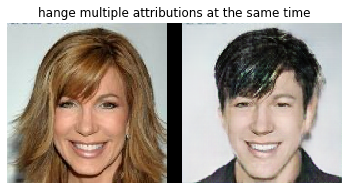

In [25]:
# change multiple attributions at the same time
test_atts = ['Pale_Skin', 'Male', 'Black_Hair']
test_ints = [1.0, 1.0, 1.0]
test_slide = False
test_int = 1.0
img = [202559]
print('Using selected images:', img)

# ==============================================================================
# =                                   graphs                                   =
# ==============================================================================

# data
sess = tl.session()
te_data = data.Celeba(dataroot, atts, img_size, 1, part='test', sess=sess, crop=not use_cropped_img, im_no=img)

# models
Genc = partial(models.Genc, dim=enc_dim, n_layers=enc_layers, multi_inputs=multi_inputs)
Gdec = partial(models.Gdec, dim=dec_dim, n_layers=dec_layers, shortcut_layers=shortcut_layers,
               inject_layers=inject_layers, one_more_conv=one_more_conv)
Gstu = partial(models.Gstu, dim=stu_dim, n_layers=stu_layers, inject_layers=stu_inject_layers,
               kernel_size=stu_kernel_size, norm=stu_norm, pass_state=stu_state)

# inputs
xa_sample = tf.placeholder(tf.float32, shape=[None, img_size, img_size, 3])
_b_sample = tf.placeholder(tf.float32, shape=[None, n_att])
raw_b_sample = tf.placeholder(tf.float32, shape=[None, n_att])

# sample
test_label = _b_sample - raw_b_sample if label == 'diff' else _b_sample
if use_stu:
    x_sample = Gdec(Gstu(Genc(xa_sample, is_training=False),
                         test_label, is_training=False), test_label, is_training=False)
else:
    x_sample = Gdec(Genc(xa_sample, is_training=False), test_label, is_training=False)
    
# ==============================================================================
# =                                    test                                    =
# ==============================================================================

# initialization
ckpt_dir = './output/%s/checkpoints' % experiment_name
tl.load_checkpoint(ckpt_dir, sess)

for idx, batch in enumerate(te_data):
    xa_sample_ipt = batch[0]
    a_sample_ipt = batch[1]
    b_sample_ipt_list = [a_sample_ipt.copy() for _ in range(n_slide if test_slide else 1)]
    
    for a in test_atts:
        i = atts.index(a)
        b_sample_ipt_list[-1][:, i] = 1 - b_sample_ipt_list[-1][:, i]
        b_sample_ipt_list[-1] = data.Celeba.check_attribute_conflict(b_sample_ipt_list[-1], atts[i], atts)
    
    x_sample_opt_list = [xa_sample_ipt, np.full((1, img_size, img_size // 10, 3), -1.0)]
    raw_a_sample_ipt = a_sample_ipt.copy()
    raw_a_sample_ipt = (raw_a_sample_ipt * 2 - 1) * thres_int
    for i, b_sample_ipt in enumerate(b_sample_ipt_list):
        print(b_sample_ipt)
        _b_sample_ipt = (b_sample_ipt * 2 - 1) * thres_int
        for t_att, t_int in zip(test_atts, test_ints):
            _b_sample_ipt[..., atts.index(t_att)] = _b_sample_ipt[..., atts.index(t_att)] * float(t_int)
            
        start_time = time.time()
        x_sample_opt_list.append(sess.run(x_sample, feed_dict={xa_sample: xa_sample_ipt,
                                                               _b_sample: _b_sample_ipt,
                                                               raw_b_sample: raw_a_sample_ipt}))
        duration = time.time() - start_time
        print('duration of process No.{} attribution({}) of image {}.png is: {}'.format(i,
                                                                                        'no-change' if i == 0 else atts[i - 1],
                                                                                        idx + 182638 if img is None else img[idx],
                                                                                        duration))
    sample = np.concatenate(x_sample_opt_list, 2)
    img = Image.fromarray(to_range(sample.squeeze(0), 0, 255, np.uint8))
    # imshow(img,'InitialMagnification', 'fit')
    plt.imshow(img)
    plt.axis('off') # 关掉坐标轴为 off
    plt.title('hange multiple attributions at the same time') # 图像题目
    plt.show()
    img.show()